In [1]:
google_colab_flag = True # Make it False if do not intend to use Google Colab and want to train in local machine!!

# For training in Google Colab
if(google_colab_flag):
  from google.colab import drive
  drive.mount('/content/drive')
  !ls
  import sys
  root_path = '/content/drive/MyDrive/Example/' # This is the path to where in google drive the code is stored!
  sys.path.append(root_path)

# For local training
else:
  root_path = ''

Mounted at /content/drive
drive  sample_data


In [2]:
import zipfile
with zipfile.ZipFile(root_path + "chest_xray.zip","r") as zip_ref:
  zip_ref.extractall(root_path + "")

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.python.keras.utils.data_utils import Sequence
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [4]:
train_path = '/content/drive/MyDrive/Example/chest_xray/train/'
valid_path = '/content/drive/MyDrive/Example/chest_xray/valid/'
test_path = '/content/drive/MyDrive/Example/chest_xray/test/'

In [5]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)


train_batches = train_datagen.flow_from_directory(
    # This is the target directory
    train_path,
    # All images will be resized to 224x224
    target_size=(224, 224),
    batch_size=32,
    # Since we use categorical_crossentropy loss, we need binary labels
    class_mode='categorical')

validation_batches = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_batches = test_datagen.flow_from_directory(
    # This is the target directory
    test_path,
    # All images will be resized to 224x224
    target_size=(224, 224),
    batch_size=32,
    # Since we use categorical_crossentropy loss, we need binary labels
    class_mode='categorical')

Found 4296 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

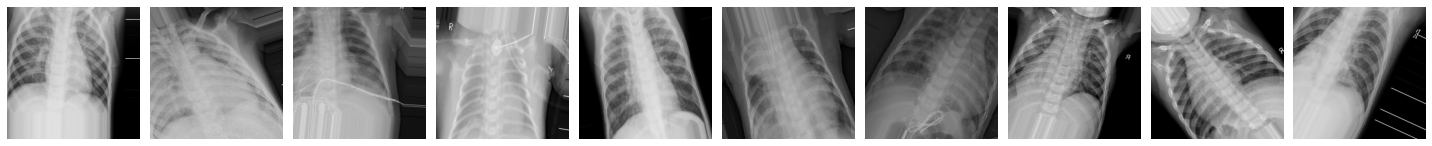

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Flatten(),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches,
          validation_data=validation_batches,
          epochs=10,
          verbose=2)

Epoch 1/10
135/135 - 110s - loss: 0.4445 - accuracy: 0.7970 - val_loss: 0.3978 - val_accuracy: 0.7767 - 110s/epoch - 814ms/step
Epoch 2/10
135/135 - 97s - loss: 0.3196 - accuracy: 0.8566 - val_loss: 0.2557 - val_accuracy: 0.9081 - 97s/epoch - 716ms/step
Epoch 3/10
135/135 - 97s - loss: 0.3023 - accuracy: 0.8582 - val_loss: 0.3829 - val_accuracy: 0.7938 - 97s/epoch - 721ms/step
Epoch 4/10
135/135 - 97s - loss: 0.2842 - accuracy: 0.8741 - val_loss: 0.2757 - val_accuracy: 0.8846 - 97s/epoch - 720ms/step
Epoch 5/10
135/135 - 96s - loss: 0.2677 - accuracy: 0.8834 - val_loss: 0.2324 - val_accuracy: 0.9092 - 96s/epoch - 710ms/step
Epoch 6/10
135/135 - 96s - loss: 0.2702 - accuracy: 0.8811 - val_loss: 0.2117 - val_accuracy: 0.9209 - 96s/epoch - 712ms/step
Epoch 7/10
135/135 - 95s - loss: 0.2416 - accuracy: 0.8976 - val_loss: 0.2019 - val_accuracy: 0.9274 - 95s/epoch - 706ms/step
Epoch 8/10
135/135 - 95s - loss: 0.2341 - accuracy: 0.9036 - val_loss: 0.2687 - val_accuracy: 0.9017 - 95s/epoch - 7

In [13]:
test_imgs, test_labels = next(test_batches)

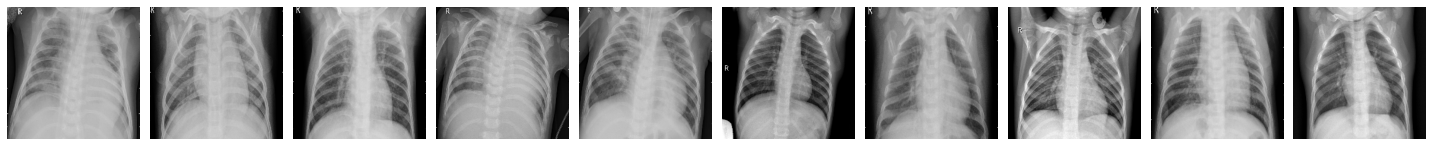

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [14]:
plotImages(test_imgs)
print(test_labels)

In [15]:
predictions = model.predict(x=test_batches, verbose=0)

In [16]:
# Evaluate the best model with testing data.
print(model.evaluate(x=test_batches))

20/20 [==============================] - 7s 338ms/step - loss: 0.3592 - accuracy: 0.8606
[0.3592243790626526, 0.8605769276618958]


In [17]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [18]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[ 55 179]
 [102 288]]


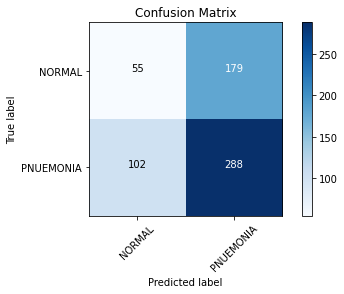

In [21]:
cm_plot_labels = ['NORMAL','PNUEMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')